In [1]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

#tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [2]:
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=2.0 * tf.ones([data_dim, latent_dim]),
                 name="w"))
    z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z")
    x = yield tfd.Normal(loc=tf.matmul(w, z),
                       scale=stddv_datapoints,
                       name="x")
    
num_datapoints = 5000
data_dim = 3
latent_dim = 1
stddv_datapoints = 0.5

Root = tfd.JointDistributionCoroutine.Root

concrete_ppca_model = functools.partial(probabilistic_pca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)


model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)

actual_w, actual_z, x_train = model.sample()


Principal axes:
tf.Tensor(
[[2.0284138]
 [2.5308614]
 [2.0540657]], shape=(3, 1), dtype=float32)


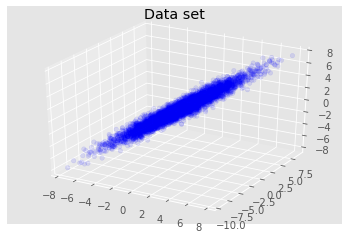

In [3]:
print("Principal axes:")
print(actual_w)

axes = plt.axes(projection='3d')
axes.scatter3D(x_train[0, :], x_train[1, :], x_train[2, :], color='blue', alpha=0.1)
plt.title("Data set")
plt.show()

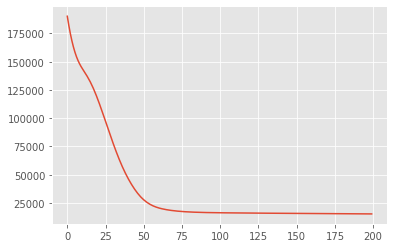

In [4]:
w = tf.Variable(tf.ones([data_dim, latent_dim]))
z = tf.Variable(tf.ones([latent_dim, num_datapoints]))

target_log_prob_fn = lambda w, z: model.log_prob(w, z, x_train)
losses = tfp.math.minimize(
    lambda: -target_log_prob_fn(w, z),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

plt.plot(losses)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[2.1380916],
       [2.6429825],
       [2.147534 ]], dtype=float32)>


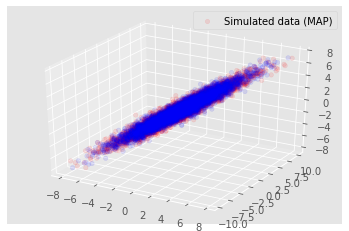

In [25]:

print("MAP-estimated axes:")
print(w)

_, _, x_generated = model.sample(value=(w, z, None))

axes = plt.axes(projection='3d')
axes.scatter3D(x_train[0, :], x_train[1, :], x_train[2, :], color='blue', alpha=0.1)
axes.scatter3D(x_generated[0, :], x_generated[1, :], x_generated[2, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.show()

Inferred axes:
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.9046911],
       [2.3568668],
       [1.9164357]], dtype=float32)>
Standard Deviation:
<TransformedVariable: dtype=float32, shape=[3, 1], fn="softplus", numpy=
array([[0.00676674],
       [0.00774535],
       [0.00662038]], dtype=float32)>


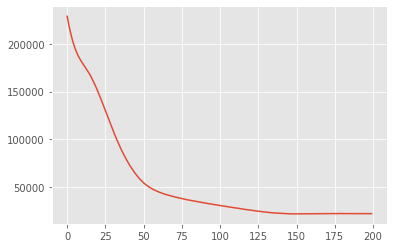

In [26]:
qw_mean = tf.Variable(tf.ones([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.ones([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([latent_dim, num_datapoints]),
    bijector=tfb.Softplus())

def factored_normal_variational_model():
    qw = yield Root(tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw"))
    qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")

surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

Num GPUs Available:  0


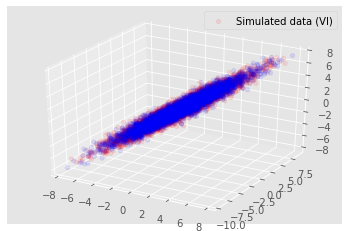

0


In [30]:
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (3, -1))[:, ::47]

axes = plt.axes(projection='3d')
axes.scatter3D(x_train[0, :], x_train[1, :], x_train[2, :], color='blue', alpha=0.1)
axes.scatter3D(x_generated[0, :], x_generated[1, :], x_generated[2, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.show()
